# Artificial Bee Colony Algorithm

In [1]:

credits = """ 
(C) Hive, Romain Wuilbercq, 2017
 
Author:
------
Romain Wuilbercq 
"""

# IMPORT MODULES
import random
import sys
import copy
import statistics as stats

# BEE CLASS

class Bee(object):
    """ Creates a bee object. """

    def __init__(self, lower, upper, fun, funcon=None):
        """
        Instantiates a bee with random properties.
        """
        # creates a random solution vector
        self._random(lower, upper)

        # checks if the problem constraint(s) are satisfied 
        if not funcon:
            self.valid = True
        else:
            self.valid = funcon(self.vector)

        # computes fitness value of a solution vector
        if (fun != None):
            self.value = fun(self.vector)
        else:
            self.value = sys.float_info.max
        self._fitness()

        # initialises trial limit counter (abandonment counter)
        self.counter = 0

    def _random(self, lower, upper):
        """ Initialises a random solution vector. """

        self.vector = []
        for i in range(len(lower)):
            self.vector.append( lower[i] + random.random() * (upper[i] - lower[i]) )

    def _fitness(self):
        """
        Evaluates the fitness value of a solution vector to measure the quality of a solution.
        """

        if (self.value >= 0):
            self.fitness = 1 / (1 + self.value)
        else:
            self.fitness = 1 + abs(self.value)

class BeeHive(object):
    """
    Creates an Artificial Bee Colony (ABC) algorithm.

    The population of the hive is composed of three distinct types
    of bees:
        1. employee bees,
        2. onlooker bee,
        3. scout bees.

    The employed bees and onlooker bees exploit the nectar
    sources around the hive (exploitation phase); whilst the
    scouts explore the solution domain (exploration phase).

    The number of nectar sources around the hive is equal to
    the number of actively employed bees and the number of employee bees
    is equal to the number of onlooker bees.
    """

    def run(self):
        """ Runs an Artificial Bee Colony (ABC) algorithm. """

        cost = {}; cost["best"] = []; cost["mean"] = []
        for itr in range(self.max_itrs):

            # employees phase
            for index in range(self.size):
                self.send_employee(index)

            # onlookers phase
            self.send_onlookers()

            # scouts phase
            self.send_scout()

            # computes best path
            self.find_best()

            # stores convergence information
            cost["best"].append( self.best )
            cost["mean"].append( sum( [ bee.value for bee in self.population ] ) / self.size )

            # prints out information about computation
            if self.verbose:
                self._verbose(itr, cost)

        return cost

    def __init__(self                 ,
                 lower, upper         ,
                 fun          = None  ,
                 numb_bees    =  30   ,
                 max_itrs     = 100   ,
                 max_trials   = None  ,
                 selfun       = None  ,
                 seed         = None  ,
                 verbose      = False ,
                 extra_params = None ,):
        """
        Instantiates a bee hive object.

        1. INITIALISATION PHASE.
        -----------------------
        The initial population of bees should cover the entire search space as
        much as possible by randomizing individuals within the search
        space constrained by the prescribed lower and upper bounds.
        """

        # checks input
        assert (len(upper) == len(lower)), "'lower' and 'upper' must be a list of the same length."

        # generates a seed for the random number generator
        if (seed == None):
            self.seed = random.randint(0, 1000)
        else:
            self.seed = seed
        random.seed(self.seed)

        # computes the number of employees
        self.size = int((numb_bees + numb_bees % 2))

        # assigns properties of algorithm
        self.dim = len(lower)
        self.max_itrs = max_itrs
        if (max_trials == None):
            self.max_trials = 0.6 * self.size * self.dim
        else:
            self.max_trials = max_trials
        self.selfun = selfun
        self.extra_params = extra_params

        # assigns properties of the optimisation problem
        self.evaluate = fun
        self.lower    = lower
        self.upper    = upper

        # initialises current best and its a solution vector
        self.best = sys.float_info.max
        self.solution = None

        # creates a bee hive
        self.population = [ Bee(lower, upper, fun) for i in range(self.size) ]

        # initialises best solution vector to food nectar
        self.find_best()

        # computes selection probability
        self.compute_probability()

        # verbosity of computation
        self.verbose = verbose

    def find_best(self):
        """ Finds current best bee candidate. """

        values = [ bee.value for bee in self.population ]
        index  = values.index(min(values))
        if (values[index] < self.best):
            self.best     = values[index]
            self.solution = self.population[index].vector

    def compute_probability(self):
        """
        Computes the relative chance that a given solution vector is
        chosen by an onlooker bee after the Waggle dance ceremony when
        employed bees are back within the hive.
        """

        # retrieves fitness of bees within the hive
        values = [bee.fitness for bee in self.population]
        max_values = max(values)

        # computes probalities the way Karaboga does in his classic ABC implementation
        if (self.selfun == None):
            self.probas = [0.9 * v / max_values + 0.1 for v in values]
        else:
            if (self.extra_params != None):
                self.probas = self.selfun(list(values), **self.extra_params)
            else:
                self.probas = self.selfun(values)

        # returns intervals of probabilities
        return [sum(self.probas[:i+1]) for i in range(self.size)]

    def send_employee(self, index):
        """
        2. SEND EMPLOYED BEES PHASE.
        ---------------------------
        During this phase, new candidate solutions are produced for
        each employed bee by cross-over and mutation of the employee bees.

        If the modified vector of the mutant bee solution is better than
        that of the original bee, the new vector is assigned to the bee.
        """

        # deepcopies current bee solution vector
        zombee = copy.deepcopy(self.population[index])

        # draws a dimension to be crossed-over and mutated
        d = random.randint(0, self.dim-1)

        # selects another bee
        bee_ix = index;
        while (bee_ix == index): bee_ix = random.randint(0, self.size-1)

        # produces a mutant based on current bee and bee's friend
        zombee.vector[d] = self._mutate(d, index, bee_ix)

        # checks boundaries
        zombee.vector = self._check(zombee.vector, dim=d)

        # computes fitness of mutant
        zombee.value = self.evaluate(zombee.vector)
        zombee._fitness()

        # deterministic crowding
        if (zombee.fitness > self.population[index].fitness):
            self.population[index] = copy.deepcopy(zombee)
            self.population[index].counter = 0
        else:
            self.population[index].counter += 1

    def send_onlookers(self):
        """
        3. SEND ONLOOKERS PHASE.
        -----------------------

        We define as many onlooker bees as there are employed bees in
        the hive since onlooker bees will attempt to locally improve the
        solution path of the employed bee they have decided to follow
        after the waggle dance phase.

        If they improve it, they will communicate their findings to the bee
        they initially watched "waggle dancing".
        """

        # sends onlookers
        numb_onlookers = 0; beta = 0
        while (numb_onlookers < self.size):

            # draws a random number from U[0,1]
            phi = random.random()

            # increments roulette wheel parameter beta
            beta += phi * max(self.probas)
            beta %= max(self.probas)

            # selects a new onlooker based on waggle dance
            index = self.select(beta)

            # sends new onlooker
            self.send_employee(index)

            # increments number of onlookers
            numb_onlookers += 1

    def select(self, beta):
        """
        4. WAGGLE DANCE PHASE.
        ---------------------
        During this 4th phase, onlooker bees are recruited using a roulette
        wheel selection.

        This phase represents the "waggle dance" of honey bees (i.e. figure-
        eight dance). By performing this dance, successful foragers
        (i.e. "employed" bees) can share, with other members of the
        colony, information about the direction and distance to patches of
        flowers yielding nectar and pollen, to water sources, or to new
        nest-site locations.

        During the recruitment, the bee colony is re-sampled in order to mostly
        keep, within the hive, the solution vector of employed bees that have a
        good fitness as well as a small number of bees with lower fitnesses to
        enforce diversity.
        """
        # computes probability intervals "online" - i.e. re-computed after each onlooker
        probas = self.compute_probability()

        # selects a new potential "onlooker" bee
        for index in range(self.size):
            if (beta < probas[index]):
                return index

    def send_scout(self):
        """
        5. SEND SCOUT BEE PHASE.
        -----------------------

        Identifies bees whose abandonment counts exceed preset trials limit,
        abandons it and creates a new random bee to explore new random area
        of the domain space. After an area has been thorougly searched, scout bees
        will attempt to find new areas for food.

        By this means, the employed bee which cannot improve their solution
        until the abandonment counter reaches the limit of trials becomes a
        scout bee. Therefore, scout bees in ABC algorithm prevent stagnation
        of employed bee population.

        This method also provides a means to overcome any local
        optima within which a bee may have been trapped.
        """

        # retrieves the number of trials for all bees
        trials = [ self.population[i].counter for i in range(self.size) ]

        # identifies the bee with the greatest number of trials
        index = trials.index(max(trials))

        # checks if its number of trials exceeds the pre-set maximum number of trials
        if (trials[index] > self.max_trials):

            # creates a new scout bee randomly
            self.population[index] = Bee(self.lower, self.upper, self.evaluate)

            # sends scout bee to exploit its solution vector
            self.send_employee(index)

    def _mutate(self, dim, current_bee, other_bee):
        """
        Mutates a given solution vector for continuous real-values.
        """

        return self.population[current_bee].vector[dim]    + \
               (random.random() - 0.5) * 2                 * \
               (self.population[current_bee].vector[dim] - self.population[other_bee].vector[dim])

    def _check(self, vector, dim=None):
        """
        Checks that a solution vector is contained within the
        pre-determined lower and upper bounds of the problem.
        """

        if (dim == None):
            range_ = range(self.dim)
        else:
            range_ = [dim]

        for i in range_:

            # checks lower bound
            if  (vector[i] < self.lower[i]):
                vector[i] = self.lower[i]

            # checks upper bound
            elif (vector[i] > self.upper[i]):
                vector[i] = self.upper[i]

        return vector

    def _verbose(self, itr, cost):
        """ Displays information about computation. """

        msg = "# Iter = {} | Best Evaluation Value = {} | Mean Evaluation Value = {} "
        print(msg.format(int(itr), cost["best"][itr], cost["mean"][itr]))

# ---- END

# Plotting Function

In [2]:
try:
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
except:
    raise ImportError("Install 'matplotlib' to plot convergence results.")

# ---- CONVERGENCE PLOT

def ConvergencePlot(cost):
    """
    Generate convergence plot.
    """

    font = FontProperties();
    font.set_size('larger');
    labels = ["Best Cost Function", "Mean Cost Function"]
    plt.figure(figsize=(12.5, 4));
    plt.plot(range(len(cost["best"])), cost["best"], label=labels[0]);
    plt.plot(range(len(cost["mean"])), cost["mean"], color='red', label=labels[1]);
    plt.xlabel("Iteration #");
    plt.ylabel("Value [-]");
    plt.legend(loc="best", prop = font);
    plt.xlim([0,len(cost["mean"])]);
    plt.grid();
    plt.show();

# Defining Optimization Problem: The Rosenbrock Function

In [5]:
import math

try:
    import numpy as np
except:
    raise ImportError("Numpy module not installed.")

# from Hive import Utilities
# from Hive import Hive


# ---- CREATE TEST CASE

def evaluator(vector, a=1, b=100):
    """
    The Rosenbrock function is a non-convex function used as a performance test
    problem for optimization algorithms introduced by Howard H. Rosenbrock in
    1960. It is also known as Rosenbrock's valley or Rosenbrock's banana
    function.
    The function is defined by
                        f(x, y) = (a-x)^2 + b(y-x^2)^2
    It has a global minimum at (x, y) = (a, a**2), where f(x, y) = 0.
    """

    vector = np.array(vector)

    return (a - vector[0])**2 + b * (vector[1] - vector[0]**2)**2

ndim = int(2)

# Creating Bee Colonies and Their Results

# Bee Colony 1  
Configuration:
*   10 maximum iterations
*   10 number of bees



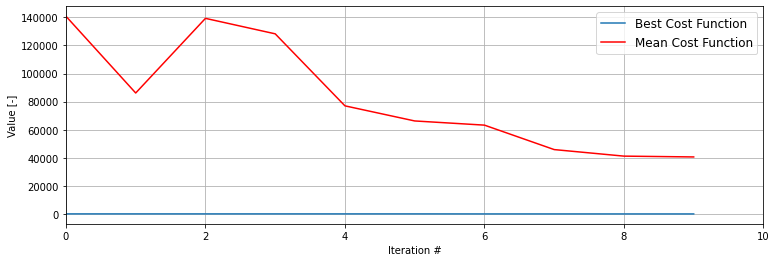

Mean Fitness Value: 82853.33377448074
Best Fitness Value: 2.3832849766699162


In [45]:
# MODEL 1
model_1 = BeeHive(    lower     = [0] *ndim ,
                      upper     = [10]*ndim ,
                      fun       = evaluator ,
                      numb_bees =  10       ,
                      max_itrs  =  10       ,)

cost_1 = model_1.run()

# plots convergence
ConvergencePlot(cost_1)

# prints out best solution
print("Mean Fitness Value:", stats.mean(cost_1['mean']))
print("Best Fitness Value: {0}".format(model_1.best))

# Bee Colony 2  
Configuration
*   100 maximum iterations
*   10 number of bees

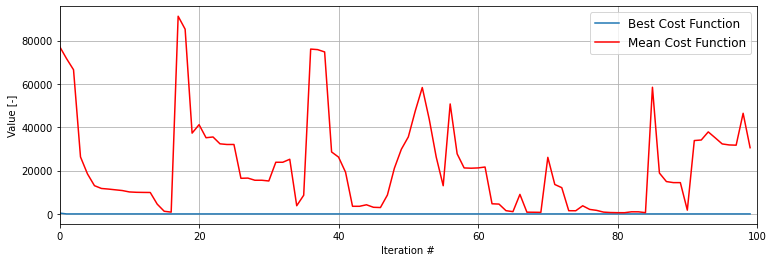

Mean Fitness Value: 22441.842493473905
Best Fitness Value: 0.8177928548214195


In [44]:
model_2 = BeeHive(     lower     = [0] *ndim ,
                      upper     = [10]*ndim ,
                      fun       = evaluator ,
                      numb_bees =  10      ,
                      max_itrs  =  100     ,)

cost_2 = model_2.run()

# plots convergence
ConvergencePlot(cost_2)

# prints out best solution
print("Mean Fitness Value:", stats.mean(cost_2['mean']))
print("Best Fitness Value: {0}".format(model_2.best))

# Bee Colony 3  
Configuration:
*   10 maximum iterations
*   100 number of bees

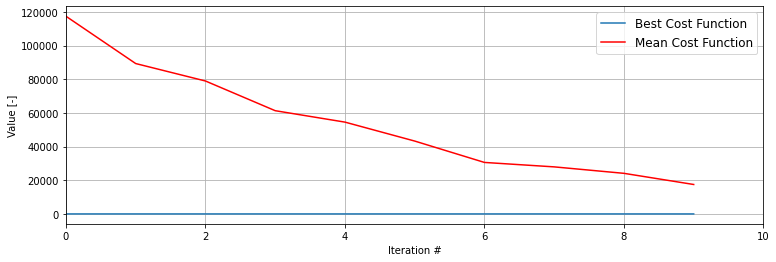

Mean Fitness Value: 54493.77607938998
Best Fitness Value: 0.3474918217855035


In [12]:
model_3 = BeeHive(    lower     = [0] *ndim ,
                      upper     = [10]*ndim ,
                      fun       = evaluator ,
                      numb_bees =  100     ,
                      max_itrs  =  10     ,)

cost_3 = model_3.run()

# plots convergence
ConvergencePlot(cost_3)

# prints out best solution
print("Mean Fitness Value:", stats.mean(cost_3['mean']))
print("Best Fitness Value: {0}".format(model_3.best))

# Bee Colony 4
Configuration:
*   100 iterations
*   50 number of bees
   



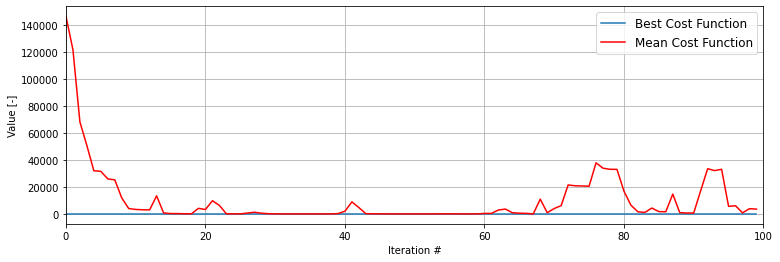

Mean Fitness Value: 10245.466924025799
Best Fitness Value: 0.06878668403780727


In [14]:
model_4 = BeeHive(    lower     = [0] *ndim ,
                      upper     = [10]*ndim ,
                      fun       = evaluator ,
                      numb_bees =  50     ,
                      max_itrs  =  100     ,)

cost_4 = model_4.run()

# plots convergence
ConvergencePlot(cost_4)

# prints out best solution
print("Mean Fitness Value:", stats.mean(cost_4['mean']))
print("Best Fitness Value: {0}".format(model_4.best))

# Bee Colony 5
Configuration:
*   100 maximum iterations
*   100 number of bees

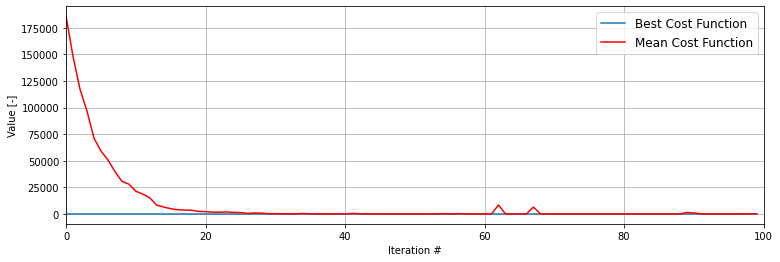

Mean Fitness Value: 9478.111049566956
Best Fitness Value: 0.01343747903065495


In [21]:
model_5 = BeeHive(    lower     = [0] *ndim ,
                      upper     = [10]*ndim ,
                      fun       = evaluator ,
                      numb_bees =  100     ,
                      max_itrs  =  100     ,)

cost_5 = model_5.run()

# plots convergence
ConvergencePlot(cost_5)

# prints out best solution
print("Mean Fitness Value:", stats.mean(cost_5['mean']))
print("Best Fitness Value: {0}".format(model_5.best))

# Colony 6
Configuraion:
*   100 iterations
*   200 bees



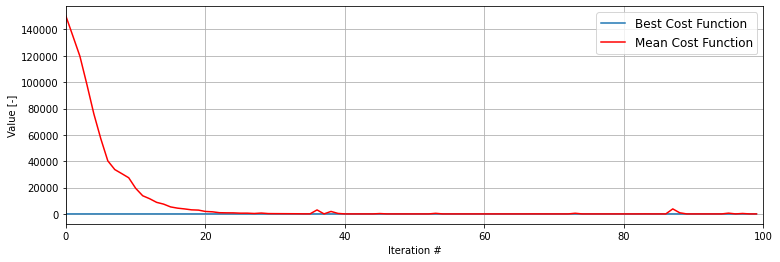

Mean Fitness Value: 8697.802470641363
Best Fitness Value: 0.009470873088036688


In [6]:
model_6 = BeeHive(    lower     = [0] *ndim ,
                      upper     = [10]*ndim ,
                      fun       = evaluator ,
                      numb_bees =  200     ,
                      max_itrs  =  100     ,)

cost_6 = model_6.run()

# plots convergence
ConvergencePlot(cost_6)

# prints out best solution
print("Mean Fitness Value:", stats.mean(cost_6['mean']))
print("Best Fitness Value: {0}".format(model_6.best))

# Results and Conclusion
Combined results

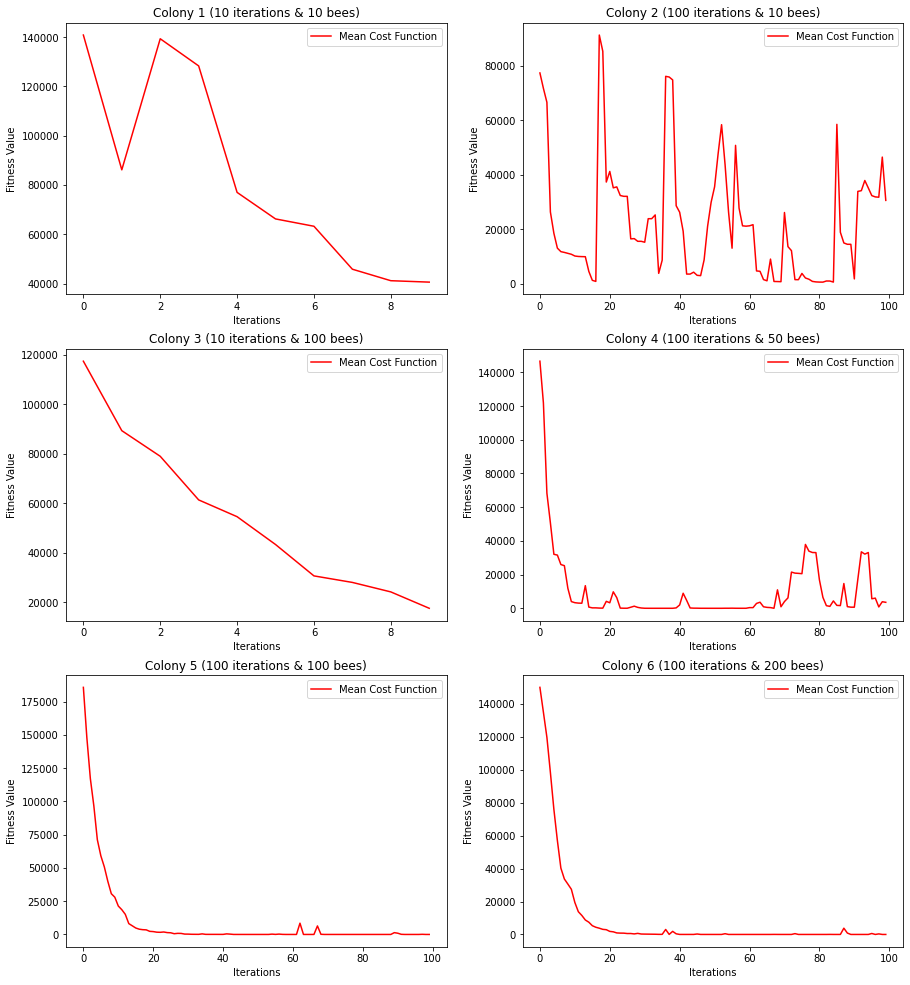

In [46]:
fig, axs = plt.subplots(3, 2, figsize=(15,17))
axs[0, 0].plot(range(len(cost_1["mean"])), cost_1["mean"], color='red', label="Mean Cost Function")
axs[0, 0].set_title('Colony 1 (10 iterations & 10 bees)')
axs[0, 0].legend()

axs[0, 1].plot(range(len(cost_2["mean"])), cost_2["mean"], color='red', label="Mean Cost Function")
axs[0, 1].set_title('Colony 2 (100 iterations & 10 bees)')
axs[0, 1].legend()

axs[1, 0].plot(range(len(cost_3["mean"])), cost_3["mean"], color='red', label="Mean Cost Function")
axs[1, 0].set_title('Colony 3 (10 iterations & 100 bees)')
axs[1, 0].legend()

axs[1, 1].plot(range(len(cost_4["mean"])), cost_4["mean"], color='red', label="Mean Cost Function")
axs[1, 1].set_title('Colony 4 (100 iterations & 50 bees)')
axs[1, 1].legend()

axs[2, 0].plot(range(len(cost_5["mean"])), cost_5["mean"], color='red', label="Mean Cost Function")
axs[2, 0].set_title('Colony 5 (100 iterations & 100 bees)')
axs[2, 0].legend()

axs[2, 1].plot(range(len(cost_6["mean"])), cost_6["mean"], color='red', label="Mean Cost Function")
axs[2, 1].set_title('Colony 6 (100 iterations & 200 bees)')
axs[2, 1].legend()

# fig.delaxes(axs[2,1])
for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel='Fitness Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# Comparing Colony 4, 5 and 6

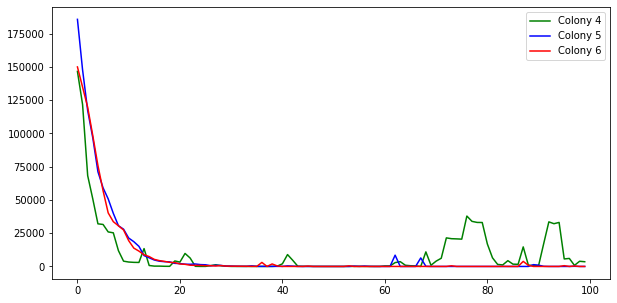

In [48]:
fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.plot(range(len(cost_4["mean"])), cost_4["mean"], color='green', label="Colony 4")
ax2.plot(range(len(cost_5["mean"])), cost_5["mean"], color='blue', label="Colony 5")
ax2.plot(range(len(cost_6["mean"])), cost_6["mean"], color='red', label="Colony 6")
plt.legend()
plt.show()

From this graph, we can see that the Mean Fitness Value of Colony 6 converges at also around iteration 30, similar to Colony 5. We can conclude that 200 bees yields very similar results to 100 bees, but requires more running and processing time. 

# All Colonies' Mean and Best Fitness Values

In [47]:
print("Colony 1 Mean Fitness Value:", stats.mean(cost_1['mean']))
print("Colony 1 Best Fitness Value: {0}".format(model_1.best))

print("\nColony 2 Mean Fitness Value:", stats.mean(cost_2['mean']))
print("Colony 2 Best Fitness Value: {0}".format(model_2.best))

print("\nColony 3 Mean Fitness Value:", stats.mean(cost_3['mean']))
print("Colony 3 Best Fitness Value: {0}".format(model_3.best))

print("\nColony 4 Mean Fitness Value:", stats.mean(cost_4['mean']))
print("Colony 4 Best Fitness Value: {0}".format(model_4.best))

print("\nColony 5 Mean Fitness Value:", stats.mean(cost_5['mean']))
print("Colony 5 Best Fitness Value: {0}".format(model_5.best))

print("\nColony 6 Mean Fitness Value:", stats.mean(cost_6['mean']))
print("Colony 6 Best Fitness Value: {0}".format(model_6.best))

Colony 1 Mean Fitness Value: 82853.33377448074
Colony 1 Best Fitness Value: 2.3832849766699162

Colony 2 Mean Fitness Value: 22441.842493473905
Colony 2 Best Fitness Value: 0.8177928548214195

Colony 3 Mean Fitness Value: 54493.77607938998
Colony 3 Best Fitness Value: 0.3474918217855035

Colony 4 Mean Fitness Value: 10245.466924025799
Colony 4 Best Fitness Value: 0.06878668403780727

Colony 5 Mean Fitness Value: 9478.111049566956
Colony 5 Best Fitness Value: 0.01343747903065495

Colony 6 Mean Fitness Value: 8697.802470641363
Colony 6 Best Fitness Value: 0.009470873088036688


# Discussion and Analysis

* With the least number of bees and iterations, Colony 1 has achieved the highest (worst) Mean Fitness Value 
of 82,853. It's Best Fitness Value is also the worst at 2.38. 


* Colony 2, having 100 iterations but only 10 bees, gained mixed and very unstable results. 
There are many instances of instability where the Mean Fitness Value spiked upwards, meaning the performance of the colony has worsened than previous iterations.

* Colony 3, having 100 bees but only 10 iterations, gained a stable downwards slope, although the Mean Fitness Value was still around 40,000 and has not yet reached 0 or the optimum range.

* Colony 4, with 100 iterations and 50  bees, although yielded better results than Colony 3, suffered unstable results from iterations 70 onwards. Thus, we have to increase the number of bees.

* Colony 5, with twice the amount of bees of Colony 4, has achieved stable results, and was able to achieve Mean Fitness Value convergence at iteration 30.

* Colony 6, with the most number of iterations and bees among the other colonies, has achieved the best results. Colony 6 has achieved the least Mean and Best Fitness Values of 8697 and 0.009 respectively, making Colony 6 the best performing colony.

* Athough Colony 6 yielded the best results, its minimum convergence started at the same time as Colony 5 at iteration 30.

# Conclusions

* By increasing the number of iterations and bees, we can gain better performance in terms of both Mean Fitness Value and Best Fitness Value. 
This is proven by the decrease of Mean Fitness Value and Best Fitness value at Colonies 4, 5 and 6.


* From the results above, we can conclude that a higher number of iterations and bees shall result in a better fitness value, both in the values of Best Fitness Value and the Mean Fitness Value.

* This is perhaps due to the fact that a higher iteration will allow the Bee Colony to reproduce more optimal bees and crossover more optimal genes, allowing it to for better   bees (solution) for tackling this problem. A higher iteration also allows more mutations to occur, which will replace the genes if its better than the previous one.


* Having a high bee population shall also allow the Colony to discover new and better solutions for the problem. A higher number of  bees allow the Colony to cover the search space as thoroughly as possible, and also to thoroughly search for un-explored regions of the search domain.

* Based on my experiments, utilizing 100 iterations and 100 bees  seems to have sufficiently reached global minium at iteration 30, and from there onwards the Mean Fitness Value has stabilized and converged reaching the global minimum. Increasing the bees to 200 have yielded better Mean and Fitness values, but converged at the same time as 100 bees.
